In [1]:
import datastore

import pandas as pd
import matplotlib.pyplot as plt

spot = datastore.getSpotPrice()

total_consumption_production = datastore.getTotalConsumptionProduction()

production_se1_mwh = datastore.getAllSE1ProductionMWh() 
production_se2_mwh = datastore.getAllSE2ProductionMWh()
production_se3_mwh = datastore.getAllSE3ProductionMWh()
production_se4_mwh = datastore.getAllSE4ProductionMWh()

transTo = datastore.getTransmissionCapTo()
transFrom = datastore.getTransmissionCapFrom()

# netFlow = datastore.getNetFlow() # Too many missing values
flow = datastore.getFlow()

capTo = datastore.getFlowCapacityTo()
capFrom = datastore.getFlowCapacityFrom()

exchangeFrom = datastore.getExchangeFrom()
exchangeTo = datastore.getExchangeTo() 

turnOver = datastore.getTurnover()

temp_pen = datastore.getDailyWeather() # DAILY celsius
wind_velocities = datastore.getHourlyWindVelocity() # m/s
hydroReservoirs = datastore.getWeeklyHydroReservs() # GWh

Missing values in Index(['spotPrice'], dtype='object') : 6
Missing values in Index(['ConsumptionGWh', 'ProductionGWh'], dtype='object') : 14
Missing values in Index(['waterSE1(MWh)', 'windSE1(MWh)', 'trmSE1MWh'], dtype='object') : 46
Missing values in Index(['waterSE2(MWh)', 'windSE2(MWh)', 'solSE2MWh', 'trmSE2MWh', 'OthSE2MWh'], dtype='object') : 144
Missing values in Index(['waterSE3(MWh)', 'windSE3(MWh)', 'nucSE3(MWh)', 'solSE3MWh',
       'trmSE3MWh', 'OthSE3MWh'],
      dtype='object') : 139
Missing values in Index(['waterSE4(MWh)', 'windSE4(MWh)', 'solSE4MWh', 'trmSE4MWh', 'OthSE4MWh'], dtype='object') : 155
Missing values in Index(['TDK1SE3', 'TNO1SE3', 'TSE2SE3', 'TF1SE3', 'TSE4SE3'], dtype='object') : 0
Missing values in Index(['TSE3DK1', 'TSE3NO1', 'TSE3SE2', 'TSE3F1', 'TSE3SE4'], dtype='object') : 0
Missing values in Index(['F_LOWSE2SE3', 'F_LOWSE3FI', 'F_LOWSE3SE4'], dtype='object') : 6289
Missing values in Index(['C_SE4SE3', 'C_DK1SE3', 'C_FISE3', 'C_NO1SE3', 'C_SE2SE3'], 

In [2]:
import calendar_features as cf

dataset = pd.concat([spot, total_consumption_production,
                     production_se1_mwh, production_se2_mwh, production_se3_mwh, production_se4_mwh, 
                     transTo, transFrom, 
                     flow, capTo, capFrom, exchangeFrom, exchangeTo,
                     turnOver, wind_velocities, hydroReservoirs, temp_pen], axis=1)

dataset.interpolate(method = 'linear', limit_direction = 'forward', inplace=True, axis=0)

# daylight_features = cf.daylight_extractor(dataset)
holiday_features = cf.get_holidays(dataset)
dataset = cf.calendar_transformer(dataset)

dataset = pd.concat([dataset, holiday_features], axis=1)
dataset = pd.get_dummies(dataset, columns=["year", "month", "day_of_week", "hour"])


dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54024 entries, 2018-01-01 00:00:00 to 2024-02-29 23:00:00
Columns: 113 entries, spotPrice to hour_23
dtypes: float64(61), int32(1), int64(1), uint8(50)
memory usage: 28.7 MB


In [17]:
import numpy as np
import tensorflow as tf
import keras

from sklearn.preprocessing import MinMaxScaler

import IPython
import IPython.display

y = dataset["spotPrice"].to_frame()
x = dataset.drop("spotPrice", axis=1)

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'
test_split = '2024-02-29 23:00:00'

train_split_index = dataset.index.get_loc(train_split)
val_split_index = dataset.index.get_loc(val_split)
test_split_index = dataset.index.get_loc(test_split)

x_train = x[:train_split_index]
y_train = y[:train_split_index]

x_scaler.fit(x_train)
y_scaler.fit(y_train)

x_val = x[train_split_index:val_split_index]
y_val = y[train_split_index:val_split_index]

x_test = x[val_split_index:test_split_index]
y_test = y[val_split_index:test_split_index]

train_df = pd.concat([pd.DataFrame(x_scaler.transform(x_train), columns=x.columns, dtype= np.float32), 
                      pd.DataFrame(y_scaler.transform(y_train), columns=["spotPrice"],dtype= np.float32)], axis=1)
val_df = pd.concat([pd.DataFrame(x_scaler.transform(x_val), columns=x.columns, dtype= np.float32), 
                    pd.DataFrame(y_scaler.transform(y_val), columns=["spotPrice"], dtype= np.float32)], axis=1)
test_df = pd.concat([pd.DataFrame(x_scaler.transform(x_test), columns=x.columns, dtype= np.float32), 
                     pd.DataFrame(y_scaler.transform(y_test), columns=["spotPrice"], dtype= np.float32)], axis=1)

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None, batch_size = 64):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    self.batch_size = batch_size

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='spotPrice', max_subplots=3):
  inputs, labels = self.example
  
  plt.figure(figsize=(12, 8))
  
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')
  
WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=self.batch_size,)

  ds = ds.map(self.split_window)
  
  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

num_features = x.shape[1] + 1

class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    
    self.lstm_cell = tf.keras.layers.LSTMCell(units=units, kernel_initializer='glorot_uniform', 
                                              recurrent_initializer='orthogonal', bias_initializer='zeros')
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    
    self.dense = tf.keras.layers.Dense(units, activation='silu')
    self.dense = tf.keras.layers.Dense(num_features)
  
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions
FeedBack.call = call
    
MAX_EPOCHS = 24 * 7
IN_STEPS = 24 * 10
OUT_STEPS = 24 * 5 

BATCH_SIZE = 64

multi_window = WindowGenerator(train_df = train_df, val_df = val_df, test_df = test_df , input_width = IN_STEPS,
                               label_width = OUT_STEPS,
                               shift = OUT_STEPS, batch_size=BATCH_SIZE)

# multi_window
inputs, labels = multi_window.example
# multi_window.plot()

def compile_and_fit(model, window, patience=5):
  
  
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=keras.losses.MeanAbsoluteError(),
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.MeanSquaredError()])

  history = model.fit(window.train, 
                      epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3080 - mean_squared_error: 0.1968 - root_mean_squared_error: 0.4437
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5304 - mean_squared_error: 21.6915 - root_mean_squared_error: 4.6571


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 112 of dimension 2 out of bounds. [Op:StridedSlice] name: strided_slice/

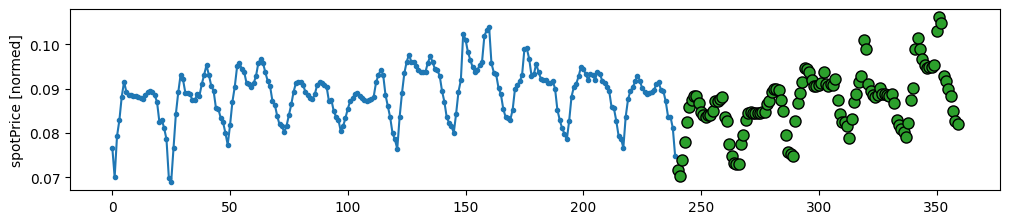

In [18]:
tf.keras.backend.clear_session()
keras.backend.clear_session()

# Single shot model
model = keras.Sequential([ 
    # Shape [batch, time, features] => [batch, lstm_units].
    keras.layers.LSTM(32, return_sequences=False, recurrent_dropout = 0, dropout = 0.2, trainable=True),
    
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # Shape => [batch, out_steps*features].
    keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=keras.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    keras.layers.Reshape([OUT_STEPS, num_features])
]) 

# AR model
# model = FeedBack(units = 64, out_steps=OUT_STEPS) 

history = compile_and_fit(model, multi_window)
IPython.display.clear_output()

multi_val_performance = {}
multi_performance = {}
multi_val_performance['LSTM'] = model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = model.evaluate(multi_window.test, verbose=1, return_dict=True)

multi_window.plot(model)

133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1361 - mean_squared_error: 0.0764 - root_mean_squared_error: 0.2764
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.3628 - mean_squared_error: 21.5875 - root_mean_squared_error: 4.6450


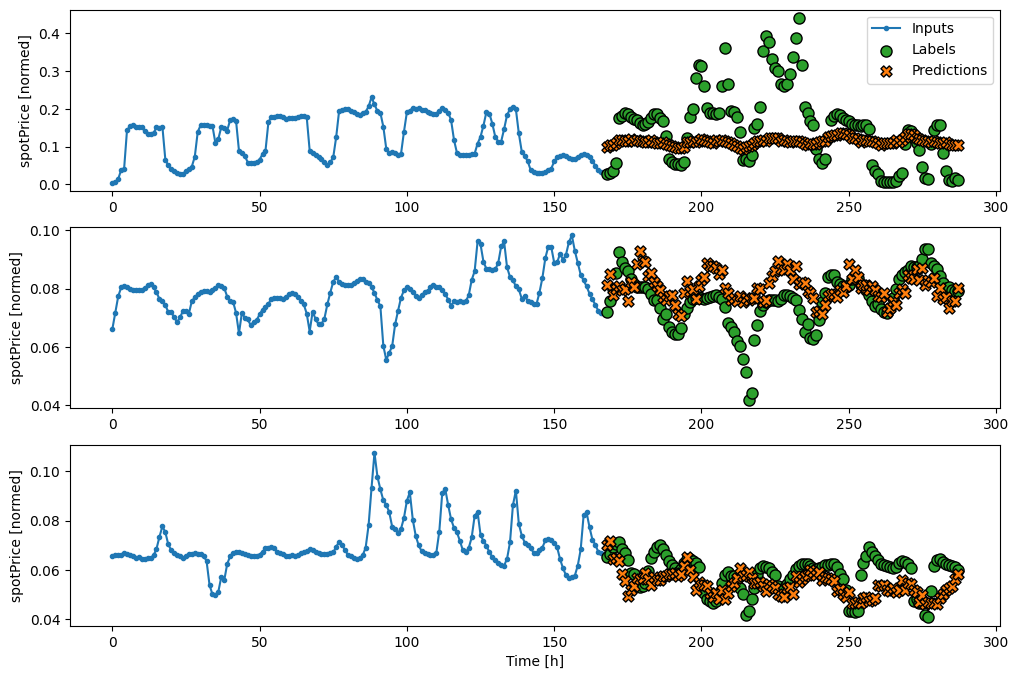

In [9]:
keras.backend.clear_session()
tf.keras.backend.clear_session()

past_inputs = keras.Input(shape=(inputs.shape[1], inputs.shape[2]))

encoder = keras.layers.LSTM(64, return_state=True, return_sequences=True, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder(past_inputs, training=True) 

decoder_lstm = keras.layers.LSTM(64, return_sequences=False)(encoder_outputs, initial_state=[state_h, state_c])
output = keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=keras.initializers.zeros())(decoder_lstm)
output = keras.layers.Reshape([OUT_STEPS, num_features])(output)

model = keras.models.Model(inputs=past_inputs, outputs=output)

history = compile_and_fit(model, multi_window)
IPython.display.clear_output()
multi_val_performance = {}
multi_performance = {}
multi_val_performance['LSTM'] = model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = model.evaluate(multi_window.test, verbose=1, return_dict=True)

multi_window.plot(model)

In [ ]:
multi_performance

{'LSTM': {'loss': 0.3505821228027344,
  'mean_squared_error': 20.94341278076172,
  'root_mean_squared_error': 4.576396942138672}}

In [14]:
multi_performance

{'LSTM': {'loss': 0.3520925045013428,
  'mean_squared_error': 21.195402145385742,
  'root_mean_squared_error': 4.603846073150635}}

In [30]:
sample = multi_window.test.take(1)
samples = 100

predictions = []
for i in range(samples):
    predictions.append(model.predict(sample, verbose=0))
    
predictions = np.array(predictions)
predictions = predictions[:, 0, :, 112]

ci_upper = np.mean(predictions, axis=0) + 1.96 * (np.std(predictions, axis=0) / np.sqrt(samples) )
ci_lower = np.mean(predictions, axis=0) - 1.96 * (np.std(predictions, axis=0) / np.sqrt(samples) )

In [38]:
sample = multi_window.test.take(1)
samples = 100

s_ = sample.as_numpy_iterator().next()
s_ = s_[1][0, :, 112]

predictions = []
for i in range(samples):
    predictions.append(model.predict(sample, verbose=0))
    
predictions = np.array(predictions)
predictions = predictions[:, 0, :, 112]

lower_int = (1. - 0.89) / 2
upper_int = 0.89 + lower_int 

ci_upper = np.quantile(predictions, lower_int, axis=0) 
ci_lower = np.quantile(predictions, upper_int, axis=0)

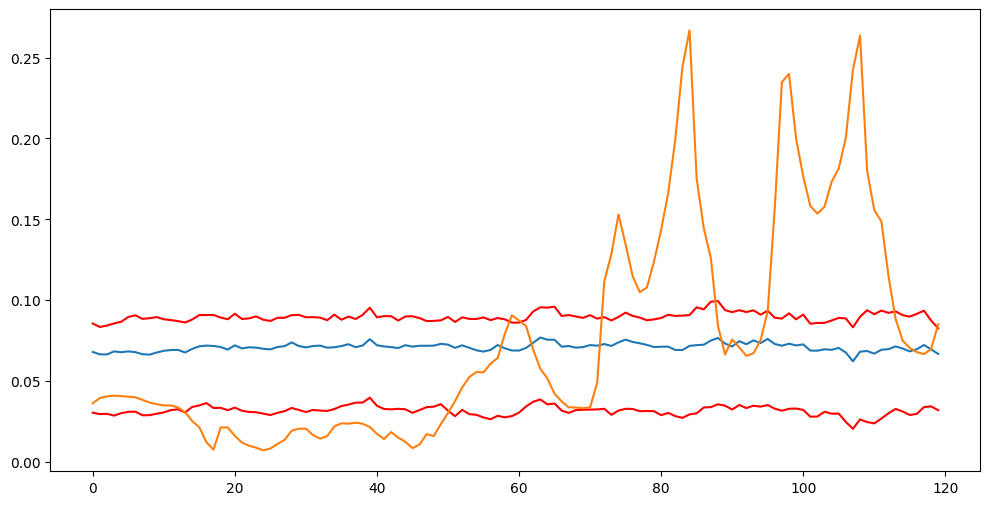

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(ci_upper, label="95% CI upper bound", color='red')
plt.plot(ci_lower, label="95% CI lower bound", color='red')
plt.plot(np.mean(predictions, axis=0), label="Mean prediction")
plt.plot(s_ , label="True value")

In [3]:
import numpy as np
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
import IPython
import IPython.display

target_scaler = MinMaxScaler()
neg_feature_scaler = MinMaxScaler()
pos_feature_scaler = MinMaxScaler()

negative_features = dataset.columns[dataset.lt(0).any()].drop("spotPrice")
positive_features = dataset.columns[dataset.gt(0).any()].drop(negative_features).drop("spotPrice")
target = dataset["spotPrice"].to_frame()

neg_features_scaled = neg_feature_scaler.fit_transform(dataset[negative_features])
pos_features_scaled = pos_feature_scaler.fit_transform(dataset[positive_features])

y = target_scaler.fit_transform(target)
x = np.concatenate([neg_features_scaled, pos_features_scaled], axis=1)

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'
test_split = '2024-02-29 23:00:00'

train_split_index = dataset.index.get_loc(train_split)
val_split_index = dataset.index.get_loc(val_split)
test_split_index = dataset.index.get_loc(test_split)

x_train = x[:train_split_index]
y_train = y[:train_split_index]

x_val = x[train_split_index:val_split_index]
y_val = y[train_split_index:val_split_index]

x_test = x[val_split_index:test_split_index]
y_test = y[val_split_index:test_split_index]

# Combine x_train and y_train into a single pandas dataframe
train_df = pd.concat([pd.DataFrame(x_train, columns=negative_features.append(positive_features)), pd.DataFrame(y_train, columns=["spotPrice"])], axis=1)
val_df = pd.concat([pd.DataFrame(x_val, columns=negative_features.append(positive_features)), pd.DataFrame(y_val, columns=["spotPrice"])], axis=1)
test_df = pd.concat([pd.DataFrame(x_test, columns=negative_features.append(positive_features)), pd.DataFrame(y_test, columns=["spotPrice"])], axis=1)


In [4]:
from utils import WindowGenerator

IN_STEPS = 24 * 5 * 2
OUT_STEPS = 24 * 5
BATCH_SIZE = 64


window = WindowGenerator(df_train = train_df, val_df = val_df, test_df = test_df, 
                         input_width = IN_STEPS, label_width = OUT_STEPS, shift = OUT_STEPS, 
                         label_columns = ["spotPrice"], batch_size=BATCH_SIZE)


inputs, labels = window.example
print(window.label_indices.shape)

for example_inputs, example_labels in window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

(120,)
Inputs shape (batch, time, features): (64, 240, 113)
Labels shape (batch, time, features): (64, 120, 1)


In [6]:
import keras
from keras.layers import LSTM, Dense, Input, Dropout, Bidirectional, Reshape
keras.utils.clear_session()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model = keras.Sequential([
    Input(shape=(inputs.shape[1], inputs.shape[2])),
    (LSTM(15, return_sequences=True)),
    Dropout(0.5),
    (LSTM(15, return_sequences=False)),
    Dropout(0.5),
    Dense(OUT_STEPS * inputs.shape[2], kernel_initializer=tf.initializers.zeros()),
    keras.layers.Reshape([OUT_STEPS, inputs.shape[2]])
    
])


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss=keras.losses.MeanAbsoluteError(), 
              metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.MeanSquaredError()])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 240, 15)        │         7,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 240, 15)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 13560)          │       216,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 120, 113)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 226,560 (885.00 KB)

 Trainable params: 226,560 (885.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from timeit import default_timer as timer
start = timer()
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')
history = model.fit(window.train,
                    epochs=1,
                    validation_data=window.val,   
                    callbacks=[early_stopping]        
                   )
end = timer()
print(end - start)

543/543 ━━━━━━━━━━━━━━━━━━━━ 28s 49ms/step - loss: 0.0267 - mean_squared_error: 0.0015 - root_mean_squared_error: 0.0361 - val_loss: 0.1116 - val_mean_squared_error: 0.0256 - val_root_mean_squared_error: 0.1600
27.776321399986045


In [23]:
predictions = model.predict(window.test)
    

154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


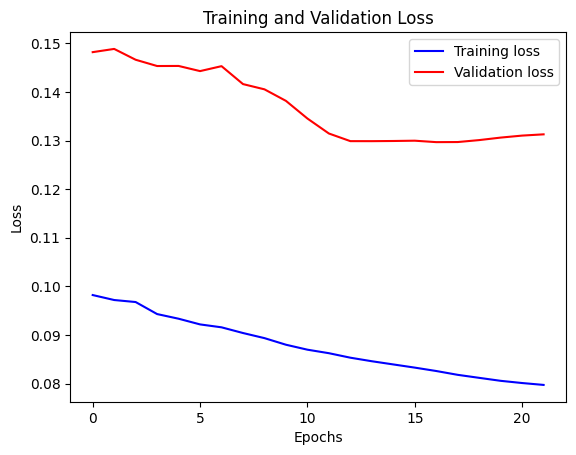

308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
MAE:  0.0032255533341177937


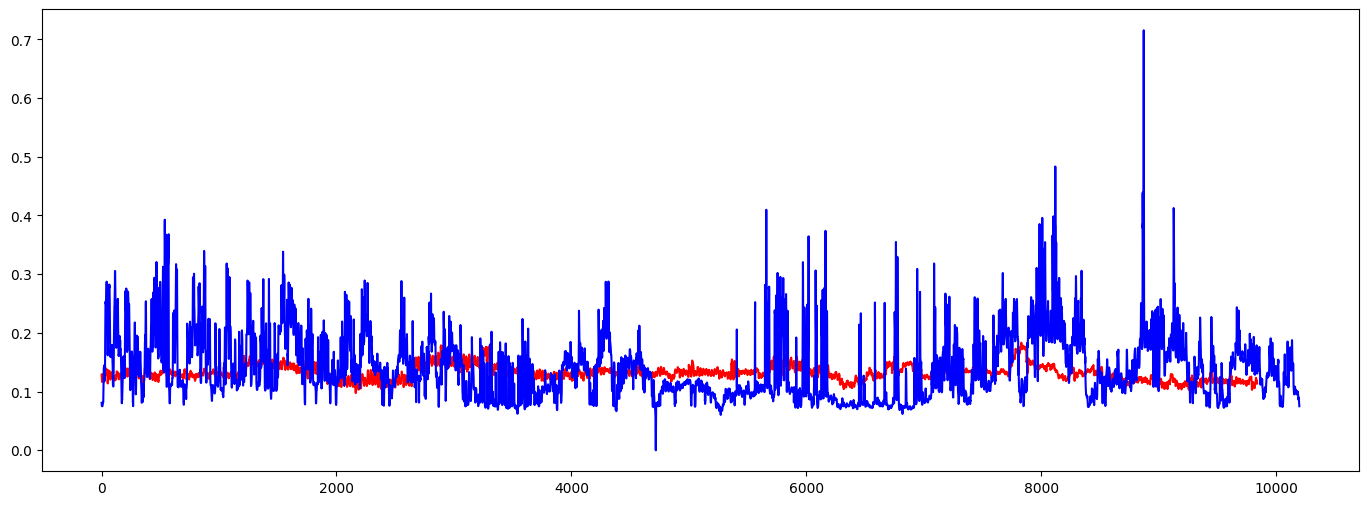

: 

In [54]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanSquaredError

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
visualize_loss(history, "Training and Validation Loss")

smape = MeanAbsolutePercentageError(symmetric=True)
mae = MeanSquaredError()

y_pred = model.predict(multi_window.test)
y_pred = y_pred[:, :, 112]
y_pred_avg = np.mean(y_pred, axis=1)
y_test_ = y_test[:-359]

print("MAE: ", mae(y_test_ , y_pred_avg))

plt.figure(figsize=(17, 6))
plt.plot(y_pred_avg, label="Predictions" , color='red')
plt.plot(y_test, label="True values", color='blue')





In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

target_scaler = MinMaxScaler(feature_range=(-1, 1))
neg_feature_scaler = MinMaxScaler(feature_range=(-1, 1))
pos_feature_scaler = MinMaxScaler(feature_range=(0, 1))

negative_features = dataset.columns[dataset.lt(0).any()].drop("spotPrice")
positive_features = dataset.columns[dataset.gt(0).any()].drop(negative_features).drop("spotPrice")
target = dataset["spotPrice"].to_frame()

neg_features_scaled = neg_feature_scaler.fit_transform(dataset[negative_features])
pos_features_scaled = pos_feature_scaler.fit_transform(dataset[positive_features])

y = target_scaler.fit_transform(target)
x = np.concatenate([neg_features_scaled, pos_features_scaled], axis=1)


def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'
test_split = '2024-02-29 23:00:00'

train_split_index = dataset.index.get_loc(train_split)
val_split_index = dataset.index.get_loc(val_split)
test_split_index = dataset.index.get_loc(test_split)

x_train = x[:train_split_index]
y_train = y[:train_split_index]

x_val = x[train_split_index:val_split_index]
y_val = y[train_split_index:val_split_index]

x_test = x[val_split_index:test_split_index]
y_test = y[val_split_index:test_split_index]

# x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
# x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
# x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

x_train, y_train = multivariate_data(x, y, 0, train_split_index, 24*5*2, 0, step=1, single_step=True)
x_val, y_val = multivariate_data(x, y, train_split_index, val_split_index, 24*5*2, 0, step=1, single_step=True)
x_test, y_test = multivariate_data(x, y, val_split_index, test_split_index, 24*5*2, 0, step=1, single_step=True)

In [15]:
import keras

past = 24 * 7 * 2 
step = 1

seq_length = int(past / step)
batch_size = 64

train_gen = keras.utils.timeseries_dataset_from_array(
    x_train, y_train, sequence_length=seq_length, sequence_stride=1, sampling_rate=1, batch_size=batch_size
)
val_gen = keras.utils.timeseries_dataset_from_array(
    x_val, y_val, sequence_length=seq_length, sequence_stride=1, sampling_rate=1, batch_size=batch_size
)
test_gen = keras.utils.timeseries_dataset_from_array(
    x_test, y_test, sequence_length=seq_length, sequence_stride=1, sampling_rate=1, batch_size=batch_size
)

for batch in train_gen.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (64, 336, 112)
Target shape: (64, 1)


In [25]:
import keras
from keras.layers import LSTM, Dense, Input, Dropout, Bidirectional
import tensorflow as tf

tf.keras.backend.clear_session()
keras.backend.clear_session()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model = keras.Sequential([
    Input(shape=(inputs.shape[1], inputs.shape[2])),
    (LSTM(32, return_sequences=True)),
    Dropout(0.2),
    (LSTM(16, return_sequences=True)),
    Dropout(0.2),
    (LSTM(16, return_sequences=True)),
    Dropout(0.2),
    (LSTM(8, return_sequences=False)),
    Dense(1, activation="linear")
])


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mae", metrics=["mse"])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 336, 32)        │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 336, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 336, 16)        │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 336, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 336, 16)        │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 336, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,617 (96.16 KB)

 Trainable params: 24,617 (96.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/44
543/543 ━━━━━━━━━━━━━━━━━━━━ 73s 132ms/step - loss: 0.0225 - mse: 0.0020 - val_loss: 0.1094 - val_mse: 0.0227
Epoch 2/44
543/543 ━━━━━━━━━━━━━━━━━━━━ 70s 128ms/step - loss: 0.0151 - mse: 6.9116e-04 - val_loss: 0.1066 - val_mse: 0.0242
Epoch 3/44
543/543 ━━━━━━━━━━━━━━━━━━━━ 71s 131ms/step - loss: 0.0140 - mse: 5.1642e-04 - val_loss: 0.1043 - val_mse: 0.0225
Epoch 4/44
543/543 ━━━━━━━━━━━━━━━━━━━━ 72s 132ms/step - loss: 0.0113 - mse: 3.5936e-04 - val_loss: 0.0998 - val_mse: 0.0196
Epoch 5/44
543/543 ━━━━━━━━━━━━━━━━━━━━ 72s 132ms/step - loss: 0.0117 - mse: 3.3234e-04 - val_loss: 0.0982 - val_mse: 0.0183
Epoch 6/44
543/543 ━━━━━━━━━━━━━━━━━━━━ 70s 128ms/step - loss: 0.0110 - mse: 2.8774e-04 - val_loss: 0.1006 - val_mse: 0.0223
Epoch 7/44
543/543 ━━━━━━━━━━━━━━━━━━━━ 71s 131ms/step - loss: 0.0111 - mse: 2.8593e-04 - val_loss: 0.0932 - val_mse: 0.0171
Epoch 8/44
543/543 ━━━━━━━━━━━━━━━━━━━━ 72s 132ms/step - loss: 0.0104 - mse: 2.5035e-04 - val_loss: 0.0989 - val_mse: 0.0184
Epoc

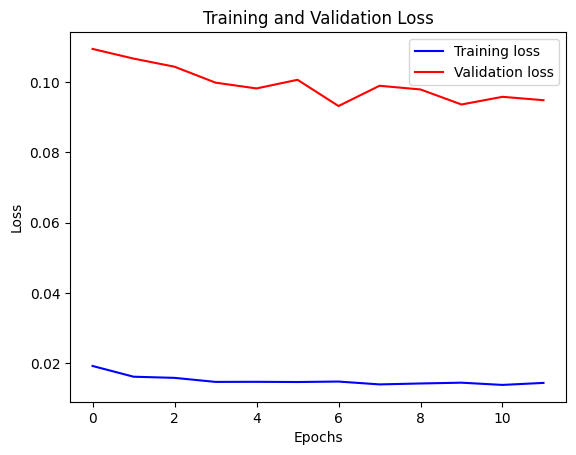

In [26]:
epochs = 44
batch_size = 64

history = model.fit(
    train_gen, 
    validation_data=val_gen,
    epochs = epochs,
    callbacks = [early_stopping],
    shuffle = False
)

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step
Mean Absolute Error: 495.61451036428315
Root Mean Squared Error: 626.3637756479757
Symmetric Mean Absolute Percentage Error: 39.13506479128927


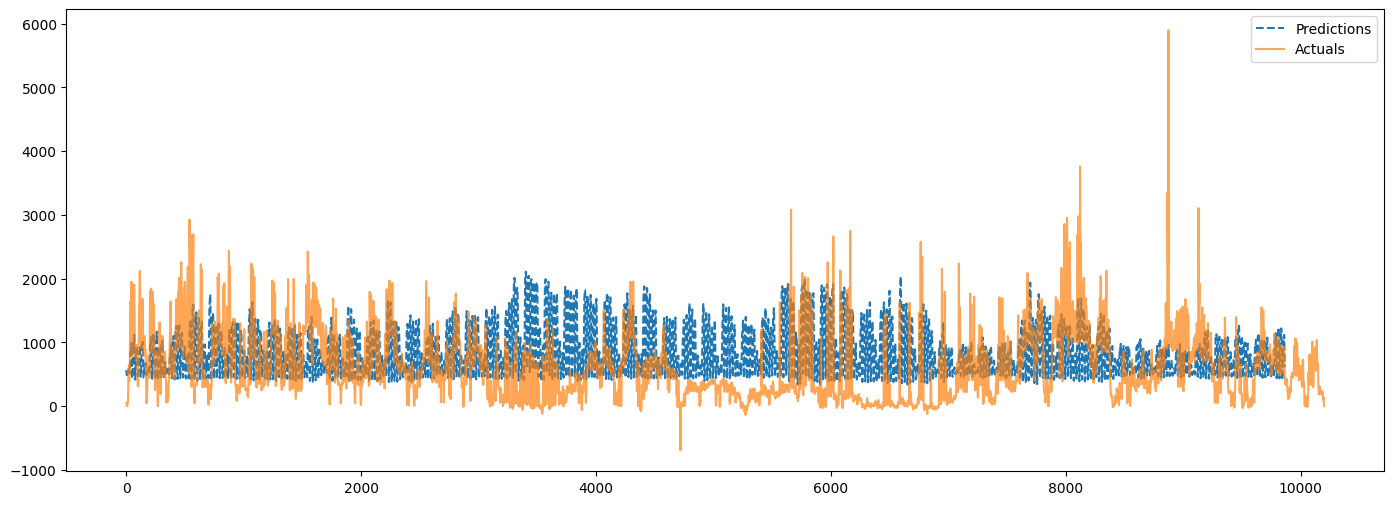

In [28]:
import numpy as np

y_pred = model.predict(test_gen)

y_pred = target_scaler.inverse_transform(y_pred)
actuals = target_scaler.inverse_transform(y_test)

actuals_ = actuals[:y_pred.shape[0]]

mae = np.mean(np.abs(y_pred - actuals_))
rmse = np.sqrt(np.mean(np.square(y_pred - actuals_))) 
smape = np.mean(np.abs(y_pred - actuals_) / (np.abs(y_pred) + np.abs(actuals_))) * 100
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("Symmetric Mean Absolute Percentage Error:", smape)

plt.figure(figsize=(17, 6))
plt.plot(y_pred, label='Predictions', linestyle='--')
plt.plot(actuals, label='Actuals', alpha=0.7)
plt.legend()
plt.show()

In [4]:
import keras
from keras.layers import LSTM, Dense, Input, Dropout, RepeatVector, TimeDistributed
keras.utils.clear_session()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model = keras.Sequential([
    Input(shape=(x_train.shape[1], x_train.shape[2])),
    (LSTM(32, return_sequences=False)),
    Dropout(0.5),
    
    RepeatVector(24*5),
    
    (LSTM(32, return_sequences=True)),
    Dropout(0.5),
    
    TimeDistributed(Dense(1, activation="linear"))
])


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mae", metrics=["mse"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │        18,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 120, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 120, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 120, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 120, 1)         │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,657 (104.13 KB)

 Trainable params: 26,657 (104.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 15
batch_size = 32

history = model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val),
    epochs = epochs,
    callbacks = [early_stopping],
    batch_size = batch_size,
    shuffle = False
)

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

Mean Absolute Error: 440.92758981831867
Root Mean Squared Error: 527.9267213207129
Symmetric Mean Absolute Percentage Error: 52.798619821731364


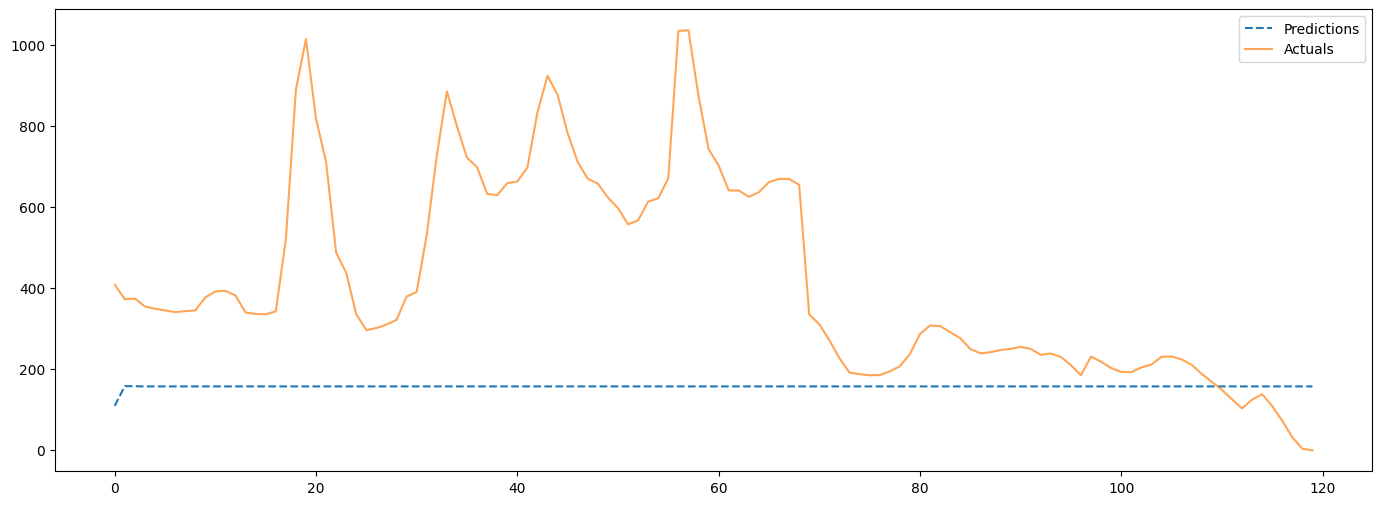

In [12]:
import numpy as np

def forecast(model, history, n_input):
 # flatten data
 data = np.array(history)
 data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
 # retrieve last observations for input data
 input_x = data[-n_input:, :]
 # reshape into [1, n_input, n]
 input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
 # forecast the next week
 yhat = model.predict(input_x, verbose=0)
 # we only want the vector forecast
 yhat = yhat[0]
 return yhat

y_pred = forecast(model, x_test , 250)

y_pred = target_scaler.inverse_transform(y_pred)
actuals = target_scaler.inverse_transform(y_test)

actuals_ = actuals[:y_pred.shape[0]]

mae = np.mean(np.abs(y_pred - actuals_))
rmse = np.sqrt(np.mean(np.square(y_pred - actuals_))) 
smape = np.mean(np.abs(y_pred - actuals_) / (np.abs(y_pred) + np.abs(actuals_))) * 100
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("Symmetric Mean Absolute Percentage Error:", smape)

plt.figure(figsize=(17, 6))
plt.plot(y_pred, label='Predictions', linestyle='--')
plt.plot(actuals[-120:], label='Actuals', alpha=0.7)
plt.legend()
plt.show()